In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import obonet
import BOCC
import pandas as pd
import numpy as np
import math
from webweb import Web
import os
import seaborn as sns
from BOCC import BOCC, load_clusters
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import typing
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from upsetplot import from_memberships
from upsetplot import plot

std_fontsize = 12

In [7]:
# Define jane's information
jane_hpos = ['HP:0002066','HP:0020221','HP:0032792','HP:0001733','HP:0001824']
jane_hpo_common_names = ['Gait ataxia','Clonic seizures','Tonic seizures','Pancreatitis','Weight loss']
jane_genes = ['SSPO','NBEA']

In [8]:
def clear_ax(ax, top=False, bottom=False, left=False, right=False):
    ax.spines['top'].set_visible(top)
    ax.spines['bottom'].set_visible(bottom)
    ax.spines['left'].set_visible(left)
    ax.spines['right'].set_visible(right)
    # ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(True)
    ax.yaxis.set_tick_params(width=0.0, labelsize=8)
    ax.xaxis.set_tick_params(width=0.0, labelsize=8)


In [9]:
# load the graphs
G = nx.read_edgelist('../Edgelists/String_HPO_2021.phenotypic_branch.edgelist.txt')
G19 = nx.read_edgelist('../Edgelists/String_HPO_2019.phenotypic_branch.edgelist.txt')
G20 = nx.read_edgelist('../Edgelists/String_HPO_2020.phenotypic_branch.edgelist.txt')
G21 = nx.read_edgelist('../Edgelists/String_HPO_2021.phenotypic_branch.edgelist.txt')
G22 = nx.read_edgelist('../Edgelists/String_HPO_2022.phenotypic_branch.edgelist.txt')

hpos = [x for x in G.nodes if 'HP:' in x]
genes = [x for x in G.nodes if 'HP:' not in x]

In [10]:
# what is the median number of PPIs
# ppi_counts = []
# for g in genes:
#     ppi_counts.append(len([x for x in G.neighbors(g) if x in genes]))

# print('Median PPI',np.median(ppi_counts))

In [11]:
# count the number of genes and HPOs in G19
print('G19 number genes:',len([x for x in G19.nodes if 'HP:' not in x]), ' number HPOs', len([x for x in G19.nodes if 'HP:' in x]))

p2p = 0 
g2g = 0
g2p = 0
for edge in G19.edges:
    if 'HP:' in edge[0] and 'HP:' in edge[1]:
        p2p += 1
    elif 'HP:' not in edge[0] and 'HP:' not in edge[1]:
        g2g += 1
    else:
        g2p += 1
print('G19 number p2p:',p2p, ' number g2g', g2g, ' number g2p', g2p)

# get the g2p edges from 2020 where both nodes exist in 2019
g2p_edges = []
for edge in G20.edges:
    # count number of HPOs
    hpo_count = sum([ 'HP:' in e for e in edge])
    if hpo_count == 1:
        # if both nodes are in the 2019 graph but there is not edge between them
        if edge[0] in G19.nodes and edge[1] in G19.nodes and not G19.has_edge(edge[0],edge[1]):
            g2p_edges.append(edge)

print('Number of g2p edges added in 2020 where both nodes exist in 2019:',len(g2p_edges))    

G19 number genes: 19536  number HPOs 14370
G19 number p2p: 18199  number g2g 5879233  number g2p 42079
Number of g2p edges added in 2020 where both nodes exist in 2019: 128798


In [12]:
# load the original clusters
# remove trival communities
def remove_trivial_coms(coms):
    keepers = []
    for c in coms:
        if len(c.members) > 2 and len(c.get_genes()) > 0 and len(c.get_genes()) != len(c.members):
            keepers.append(c)
    return keepers

g_coms = load_clusters('../Clusters/2021/greedy.2021.coms.txt')
w_coms = load_clusters('../Clusters/2021/walktrap.2021.coms.txt')
i_coms = load_clusters('../Clusters/2021/infomap.2021.coms.txt')
c_coms = load_clusters('../Clusters/2021/cesna.2021.coms.txt')

In [13]:
# do the same things as above but with the paris 2021 crosses
g_subcoms = load_clusters('../SubComs/2021/paris.greedy.2021.coms.txt')
w_subcoms = load_clusters('../SubComs/2021/paris.walktrap.2021.coms.txt')
i_subcoms = load_clusters('../SubComs/2021/paris.infomap.2021.coms.txt')
c_subcoms = load_clusters('../SubComs/2021/paris.cesna.2021.coms.txt')

print('# sub clusters',sum([len(g_subcoms),len(w_subcoms),len(i_subcoms),len(c_subcoms)]))
g_subcoms = remove_trivial_coms(g_subcoms)
w_subcoms = remove_trivial_coms(w_subcoms)
i_subcoms = remove_trivial_coms(i_subcoms)
c_subcoms = remove_trivial_coms(c_subcoms)
print('# non-trivial sub clusters',sum([len(g_subcoms),len(w_subcoms),len(i_subcoms),len(c_subcoms)]))

# sub clusters 32767
# non-trivial sub clusters 3696


In [14]:
# do the same things as above but with the paris 2020 crosses
g_subcoms_20 = load_clusters('../SubComs/2020/paris.greedy.2020.coms.txt')
w_subcoms_20 = load_clusters('../SubComs/2020/paris.walktrap.2020.coms.txt')
i_subcoms_20 = load_clusters('../SubComs/2020/paris.infomap.2020.coms.txt')
c_subcoms_20 = load_clusters('../SubComs/2020/paris.cesna.2020.coms.txt')

print('# 2020 sub clusters',sum([len(g_subcoms),len(w_subcoms),len(i_subcoms),len(c_subcoms)]))
g_subcoms_20 = remove_trivial_coms(g_subcoms_20)
w_subcoms_20 = remove_trivial_coms(w_subcoms_20)
i_subcoms_20 = remove_trivial_coms(i_subcoms_20)
c_subcoms_20 = remove_trivial_coms(c_subcoms_20)
print('# 2020 non-trivial sub clusters',sum([len(g_subcoms),len(w_subcoms),len(i_subcoms),len(c_subcoms)]))

# 2020 sub clusters 3696
# 2020 non-trivial sub clusters 3696


In [15]:
# load 2019 sub clusters
g_subcoms_19 = load_clusters('../SubComs/2019/paris.greedy.2019.coms.txt')
w_subcoms_19 = load_clusters('../SubComs/2019/paris.walktrap.2019.coms.txt')
i_subcoms_19 = load_clusters('../SubComs/2019/paris.infomap.2019.coms.txt')
c_subcoms_19 = load_clusters('../SubComs/2019/paris.cesna.2019.coms.txt')

# remove trivial
g_subcoms_19 = remove_trivial_coms(g_subcoms_19)
w_subcoms_19 = remove_trivial_coms(w_subcoms_19)
i_subcoms_19 = remove_trivial_coms(i_subcoms_19)
c_subcoms_19 = remove_trivial_coms(c_subcoms_19)


In [16]:
"""
can you send me a file that is “cluser_id cluster_score gene_name num_g2p_connections num_pottential_g2p_connections”
one file per algorithm?
the last two columns are intra cluster
"""
# predicted_df = pd.read_csv('../XGBoost2021ClusterRankings.csv')
cluster_scores = {}
first= True
for line in open('../XGBoost2021ClusterRankings.csv','r'):
    if first:
        first = False
        continue
#     print(line)
    row = line.strip().split(',')
    cluster_scores[row[0]] = 1 - float(row[1])
    
def export_gene_in_cluster_stats(coms,g,scores,prefix,outfile):
    data_to_save = {'com_id':[],'cluster_score':[],'genes':[],'num_g2p_connections':[],'num_potential_g2p_connections':[]}
    for com in coms:
        com_name = prefix + com.name
        if com_name not in scores:
            continue
        genes = [n for n in com.members if 'HP:' not in n]
        hpos = [n for n in com.members if 'HP:' in n]
        g2 = g.subgraph(com.members)
        # count the number of g2p connects in each cluster
        for gene in genes:
            #get the number of HPO neighbors of gene
            num_hpo_neighbors = len([n for n in g2.neighbors(gene) if 'HP:' in n])
            num_possible_new_g2p = len(hpos) - num_hpo_neighbors
    #         print(num_g2p, num_possible_new_g2p)
            data_to_save['com_id'].append(com_name)
            data_to_save['cluster_score'].append(scores[com_name])
            data_to_save['genes'].append(gene)
            data_to_save['num_g2p_connections'].append(num_hpo_neighbors)
            data_to_save['num_potential_g2p_connections'].append(num_possible_new_g2p)
    tmp_df = pd.DataFrame(data_to_save)
    tmp_df.to_csv(outfile,sep='\t',index=False)

export_gene_in_cluster_stats(w_subcoms,G21,cluster_scores,'paris.walktrap.2021:','paris.walktrap.2021.g2p_counts.tsv')
export_gene_in_cluster_stats(g_subcoms,G21,cluster_scores,'paris.greedy.2021:','paris.greedy.2021.g2p_counts.tsv')
export_gene_in_cluster_stats(i_subcoms,G21,cluster_scores,'paris.infomap.2021:','paris.infomap.2021.g2p_counts.tsv')
export_gene_in_cluster_stats(c_subcoms,G21,cluster_scores,'paris.cesna.2021:','paris.cesna.2021.g2p_counts.tsv')

In [17]:
print('# all clusters',sum([len(g_coms),len(w_coms),len(i_coms),len(c_coms),]))

g_coms = remove_trivial_coms(g_coms)
w_coms = remove_trivial_coms(w_coms)
i_coms = remove_trivial_coms(i_coms)
c_coms = remove_trivial_coms(c_coms)

print('# non-trivial clusters',sum([len(g_coms),len(w_coms),len(i_coms),len(c_coms)]))

# all clusters 27809
# non-trivial clusters 1970


## Yearly Stats

In [18]:
# count node and edge type stats
def count_size_stats(_G):
    # count genes
    num_genes = sum(['HP:' not in n for n in _G.nodes])
    # count HPOs
    num_hpos = sum(['HP:' in n for n in _G.nodes])
    # 0 = p2p, 1 = p2g, 2 = p2p
    hpo_counts = [ sum(['HP:' in x for x in e]) for e in _G.edges]
    # count g2p
    num_g2p = hpo_counts.count(1)
    # count g2g
    num_p2p = hpo_counts.count(2)
    # count p2p
    num_g2g = hpo_counts.count(0)
    return [num_genes, num_hpos, num_p2p, num_g2p, num_g2g]

plt_data = {'year':[],'type':[],'count':[]}
# for y,_g in zip(list(range(2015,2023)),[G15,G16,G17,G18,G19,G20,G21]):
for y,_g in zip(list(range(2019,2023)),[G19,G20,G21,G22]):    
    stats = count_size_stats(_g)
    for t,x in zip(['STRING nodes', 'HPO nodes', 'HPO edges', 'gene-to-phenotype edges', 'STRING edges'],stats):
        plt_data['year'].append(y)
        plt_data['type'].append(t)
        plt_data['count'].append(x)
plt_df = pd.DataFrame(plt_data)

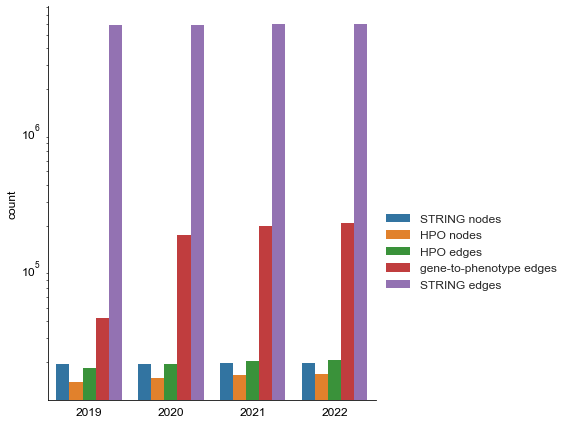

In [19]:
# plt.figure(figsize = (6,6))
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

# sns.catplot(
#     data=plt_df, kind="bar",
#     x="year", y="count", hue="type",
#     ci="sd",ax=ax)

sns.barplot(data=plt_df,x='year',y='count',hue='type',ax=ax)
sns.set_style("whitegrid", {'axes.grid' : False})

clear_ax(ax,bottom=True, left=True)

plt.legend(frameon=False,title=None,bbox_to_anchor=(1, 0.5),fontsize=std_fontsize)
plt.yscale('log')
ax.set_xlabel('')
plt.xticks(fontsize=std_fontsize)
plt.yticks(fontsize=std_fontsize)
plt.ylabel('count',fontsize=std_fontsize)
plt.tight_layout()
plt.savefig('../PublicationFigures/yearly_stats.png',dpi=300)
plt.show()

In [20]:
yearly_changes = {'year':[],'type':[],'change':[]}
# calculate the difference from previous years
for year in range(2019,2023):
    next_year = year
    sub = plt_df[plt_df['year'] == 2019]
    next_sub = plt_df[plt_df['year'] == next_year]
    for t in sub['type'].unique():
        sub_type_value = int(sub[sub['type'] == t]['count'])
        next_sub_type_value = int(next_sub[next_sub['type'] == t]['count'])
        difference = next_sub_type_value - sub_type_value
        percent_change = difference/sub_type_value
#         print(year,t,percent_change)
#         print(year,t,difference)
#         print()
        yearly_changes['year'].append(year)
        yearly_changes['type'].append(t)
        yearly_changes['change'].append(percent_change)
yearly_change_df = pd.DataFrame(yearly_changes)

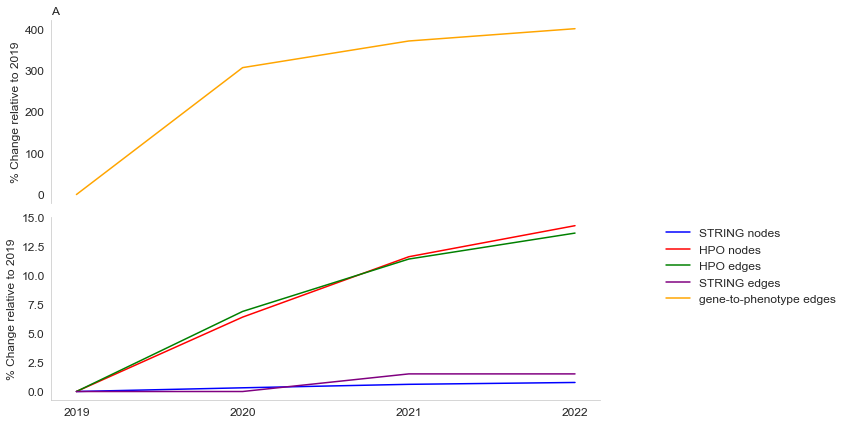

In [35]:
# print(yearly_change_df)
fig, ax = plt.subplots(2)
fig.set_size_inches(12, 6)
yearly_change_df['percent_change'] = [ round(x*100,2) for x in yearly_change_df['change']]
handles = []
colors = ['blue','red','green','orange','purple']
for i,t in enumerate(yearly_change_df['type'].unique()):
    if t == 'gene-to-phenotype edges':
        continue
    sub = yearly_change_df[yearly_change_df['type'] == t]
    ax[1].plot(sub['year'],sub['percent_change'], color=colors[i])
    legend_piece = Line2D([0], [0], color=colors[i], label=t)
    handles.append(legend_piece)

sub = yearly_change_df[yearly_change_df['type'] == 'gene-to-phenotype edges']
ax[0].plot(sub['year'],sub['percent_change'],label='gene-to-phenotype edges',color=colors[-2])
legend_piece = Line2D([0], [0],color=colors[-2], label='gene-to-phenotype edges')
handles.append(legend_piece)
    
ax[0].set_xticks([])
ax[1].set_xticks([2019,2020,2021,2022])


clear_ax(ax[0],bottom=False, left=True)
clear_ax(ax[1],bottom=True, left=True)

ax[1].tick_params(axis='both', which='major', labelsize=std_fontsize)
ax[1].tick_params(axis='both', which='minor', labelsize=std_fontsize)

ax[0].tick_params(axis='both', which='major', labelsize=std_fontsize)
ax[0].tick_params(axis='both', which='minor', labelsize=std_fontsize)


ax[0].set_ylabel('% Change relative to 2019', fontsize=std_fontsize)
ax[1].set_ylabel('% Change relative to 2019', fontsize=std_fontsize)

ax[1].legend(handles=handles, bbox_to_anchor=(1.1, 1), frameon=False, fontsize=std_fontsize)
ax[0].set_title('A',loc='left',fontsize=std_fontsize)
plt.tight_layout()

plt.savefig('../PublicationFigures/yearly_change_stats.png',dpi=300)

plt.show()


## Cluster & Sub Cluster Size

0 greedy
1 walktrap
2 infomap
3 cesna
0 greedy-paris
1 walktrap-paris
2 infomap-paris
3 cesna-paris


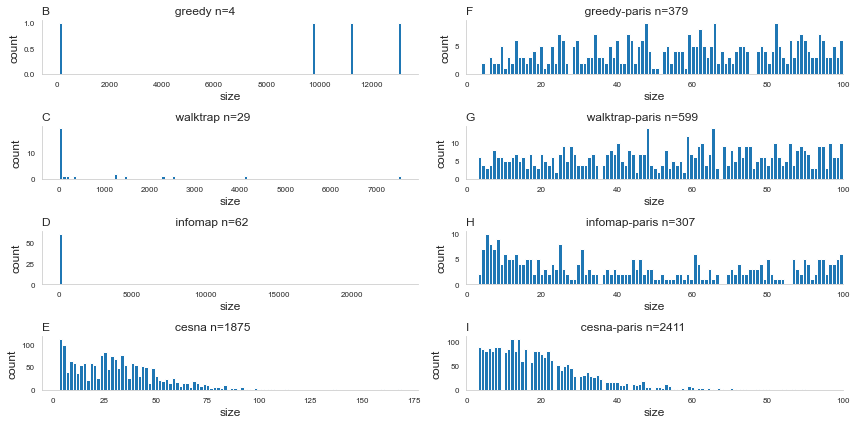

In [34]:
# plot size distribution of original coms
fig, axes = plt.subplots(4,2)
fig.set_size_inches(12, 6)

spaces = '                                     '
letters = ['B','C','D','E']
for i,n in enumerate(zip([g_coms,w_coms,i_coms,c_coms],['greedy','walktrap','infomap','cesna'])):
    print(i,n[1])
    xs = [ len(c.members) for c in n[0]]
    ys = [ len(c.get_genes()) / (len(c.members) - len(c.get_genes())) if len(c.get_genes()) != len(c.members) else 1 for c in n[0]]
    axes[i,0].set_title('{letter}{spaces}{algo} n={n}'.format(algo=n[1],n=str(len(n[0])),letter=letters[i],spaces=spaces),loc='left')
    axes[i,0].hist(xs,bins=100)
    axes[i,0].set_xlabel('size',fontsize=std_fontsize)
    axes[i,0].set_ylabel('count',fontsize=std_fontsize)
    clear_ax(axes[i,0],bottom=True, left=True)

spaces = '                                 '
letters = ['F','G','H','I']
for i,n in enumerate(zip([g_subcoms,w_subcoms,i_subcoms,c_subcoms],['greedy-paris','walktrap-paris','infomap-paris','cesna-paris'])):
    print(i,n[1])
    xs = [ len(c.members) for c in n[0]]
    ys = [ len(c.get_genes()) / (len(c.members) - len(c.get_genes())) if len(c.get_genes()) != len(c.members) else 1 for c in n[0]]
    axes[i,1].set_title('{letter}{spaces}{algo} n={n}'.format(algo=n[1],n=str(len(n[0])),letter=letters[i],spaces=spaces),loc='left',fontsize=std_fontsize)
    axes[i,1].hist(xs,bins=100)
    axes[i,1].set_xlabel('size',fontsize=std_fontsize)
    axes[i,1].set_xlim((0,100))
    axes[i,1].set_ylabel('count',fontsize=std_fontsize)
    clear_ax(axes[i,1],bottom=True, left=True)
plt.tight_layout()
plt.savefig('../PublicationFigures/clusters_2021_non_trivial_size_dist.png',dpi=300)
plt.show()


## Network growth + cluster size figure

## Snowball simulation results

In [23]:
# load rediscovery stats
g_snow = pd.read_csv('../SnowballResultsFixed/snowball.paris.greedy.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
w_snow = pd.read_csv('../SnowballResultsFixed/snowball.paris.walktrap.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
i_snow = pd.read_csv('../SnowballResultsFixed/snowball.paris.infomap.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
c_snow = pd.read_csv('../SnowballResultsFixed/snowball.paris.cesna.String_HPO_2020.phenotypic_branch.tsv',sep='\t')
print(g_snow.shape)
print(w_snow.shape)
print(i_snow.shape)
print(c_snow.shape)

(182900, 5)
(80400, 5)
(385500, 5)
(2847100, 5)


In [24]:
def control_inf(x):
    if math.isinf(x):
#         print('Inf')
        return 1
    elif x == 0 or math.isnan(x):
#         print('Zero')
        return 0
    else:
#         if math.isnan(np.log2(x)):
#             print(x)
        return np.log2(x)

## Distribution of emprical p-values

In [25]:
def log_2_ratio(o: int, e: typing.List[int]) -> float:
    """
    param o: observed number of rediscoveries
    param e: list of expected number of rediscoveries based on the null model
    """
    return float(np.log2(o / np.median(np.array(e))))

def empircal_p(o: int, e: typing.List[int]) -> float:
    """
    param o: observed number of rediscoveries
    param e: list of expected number of rediscoveries based on the null model
    """
    return float(1 - (sum([ o > x for x in e]) / len(e)))

l2r_p = {'algorithm':[],'cluster_id':[],'log2ratio':[],'p-value':[],'has_a_rediscovery':[],'num_rediscoveries':[]}

# test the functions
assert(log_2_ratio(2,[2,2,2]) == 0)
assert(log_2_ratio(2,[1,1,1]) > 0)
assert(log_2_ratio(2,[3,3,3]) < 0)
assert(empircal_p(2,[2,2,2]) == 1)
assert(empircal_p(2,[1,1,1]) == 0)
assert(round(empircal_p(2,[3,1,1]),2) == round(float(1/3),2))

algos = ['greedy-paris','walktrap-paris','infomap-paris','cesna-paris']
# calc log2ratio and p value for each cluster in each algo category. Save it all in one dataframe
expecteds = {}
for df,algo in zip([g_snow, w_snow, i_snow, c_snow],algos):
    expecteds[algo] = []
    for cid in df['com_id'].unique():
        sub = df[df['com_id'] == cid]
        observed = list(sub['com_score'])[0]
        expected = list(sub['replicate_score'])
        expecteds[algo] += expected
        l2r = log_2_ratio(observed,expected)
        p = empircal_p(observed,expected)
        l2r_p['algorithm'].append(algo)
        l2r_p['cluster_id'].append(cid)
        l2r_p['log2ratio'].append(l2r)
        l2r_p['p-value'].append(p)
        l2r_p['has_a_rediscovery'].append(observed > 0)
        l2r_p['num_rediscoveries'].append(observed)
l2r_p_df = pd.DataFrame(l2r_p)
print(l2r_p_df.columns)
print(l2r_p_df.shape)

/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_2511/3063003636.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_2511/3063003636.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  return float(np.log2(o / np.median(np.array(e))))
/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_2511/3063003636.py:6: RuntimeWarning: divide by zero encountered in log2
  return float(np.log2(o / np.median(np.array(e))))


Index(['algorithm', 'cluster_id', 'log2ratio', 'p-value', 'has_a_rediscovery',
       'num_rediscoveries'],
      dtype='object')
(34959, 6)


In [26]:
og_df = l2r_p_df.copy()
print(og_df['algorithm'].unique())

['greedy-paris' 'walktrap-paris' 'infomap-paris' 'cesna-paris']


#### Remove trivial clusters from the snowballing results

In [27]:
l2r_p_df = og_df.copy()
print(l2r_p_df)
l2r_p_df['algorithm2'] = [ x.split('-')[1] + '.' + x.split('-')[0] for x in l2r_p_df['algorithm']]
l2r_p_df['uid'] = l2r_p_df['algorithm2'] + '.2020:' + l2r_p_df['cluster_id'].astype(str)
# l2r_p_df['uid'] = [ x.replace('-','.') for x in l2r_p_df['uid']]
print(l2r_p_df)
non_trivial_sub_coms = []
for algo,subcoms_ittr in zip(['greedy','walktrap','infomap','cesna'],
                             [g_subcoms_20,w_subcoms_20,i_subcoms_20,c_subcoms_20]):
    for com in subcoms_ittr:
        non_trivial_sub_coms.append('paris.{}.2020:{}'.format(algo,str(com.name)))

print(len(non_trivial_sub_coms))
print(non_trivial_sub_coms[0:15])
print(l2r_p_df.shape)
og_num_clsuters = l2r_p_df.shape[0]
l2r_p_df = l2r_p_df[l2r_p_df['uid'].isin(non_trivial_sub_coms)]
print(l2r_p_df.shape)


print(sum(l2r_p_df['has_a_rediscovery']))
print('% clusters with a rediscovery (counting trivial): {}'.format(sum(l2r_p_df['has_a_rediscovery'])/og_num_clsuters))
print('% clusters with a rediscovery (excluding trivial): {}'.format(sum(l2r_p_df['has_a_rediscovery'])/l2r_p_df.shape[0]))

          algorithm  cluster_id  log2ratio  p-value  has_a_rediscovery  \
0      greedy-paris           0        NaN      1.0              False   
1      greedy-paris           1        NaN      1.0              False   
2      greedy-paris           2        NaN      1.0              False   
3      greedy-paris           3        NaN      1.0              False   
4      greedy-paris           4        NaN      1.0              False   
...             ...         ...        ...      ...                ...   
34954   cesna-paris       28466        NaN      1.0              False   
34955   cesna-paris       28467        NaN      1.0              False   
34956   cesna-paris       28468        NaN      1.0              False   
34957   cesna-paris       28469        NaN      1.0              False   
34958   cesna-paris       28470        NaN      1.0              False   

       num_rediscoveries  
0                      0  
1                      0  
2                      0  
3  

## Of the clusters that have atleast 1 rediscovery, what is the distribution of p-values?

total number of clusters with a rediscovery 524
total number of non-trivial clusters 3119
% with atleast 1 rediscovery 0.16800256492465535
greedy-paris No rediscoveries	 352
greedy-paris Rediscoveries	 89
greedy-paris Total 441

walktrap-paris No rediscoveries	 64
walktrap-paris Rediscoveries	 39
walktrap-paris Total 103

infomap-paris No rediscoveries	 210
infomap-paris Rediscoveries	 75
infomap-paris Total 285

cesna-paris No rediscoveries	 1969
cesna-paris Rediscoveries	 321
cesna-paris Total 2290



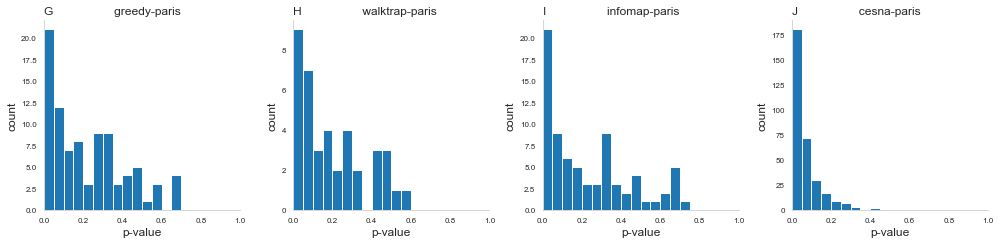

In [33]:
#print how many have and do not have rediscoveries
print('total number of clusters with a rediscovery',l2r_p_df['has_a_rediscovery'].sum())
# total number of clusters
print('total number of non-trivial clusters', l2r_p_df.shape[0])
print('% with atleast 1 rediscovery', l2r_p_df['has_a_rediscovery'].sum() / l2r_p_df.shape[0])
fig, ax = plt.subplots(1,4)
fig.set_size_inches(14, 3.5)
letters = ['G','H','I','J']
for i,algo in enumerate(l2r_p_df['algorithm'].unique()):
    sub = l2r_p_df[l2r_p_df['algorithm'] == algo]
    subsub = sub[sub['has_a_rediscovery'] == True]
    print(algo, 'No rediscoveries\t', sub.shape[0] - sub['has_a_rediscovery'].sum())
    print(algo, 'Rediscoveries\t', sub['has_a_rediscovery'].sum())
    print(algo, 'Total', sub.shape[0])
    print()
    # specify bins for hist that are 0 - 1 by 0.05
    # list(range(0,1.05,0.05))
    ax[i].hist(subsub['p-value'], bins=20, range=(0,1))
    ax[i].set_title(letters[i] + '                  ' + algo,loc='left',fontsize=std_fontsize)
    ax[i].set_xlabel('p-value',fontsize=std_fontsize)
    ax[i].set_ylabel('count',fontsize=std_fontsize)
    # set x range 0 - 1
    ax[i].set_xlim((0,1))
    clear_ax(ax[i],bottom=True, left=True)
plt.tight_layout()
plt.savefig('../PublicationFigures/rediscovery_p_values.filtered.png',dpi=300)


## Edge Uniqueness

In [24]:
# get a list of rediscoveries per algo
def rediscover(edges,coms):
    """
    @param edges: list of edges [[node1,node2],[node1,node3],..]
    @param coms: list of BOCC objects
    """
    rediscoveries = list()
    for com in coms:
        for edge in edges:
            edge = list(edge)
            if edge[0] in com.members and edge[1] in com.members:
                edge.sort()
                rediscoveries.append(str(edge))
#                 print(com.name,edge)
    return rediscoveries

def rediscover_with_com_id(edges,coms):
    """
    @param edges: list of edges [[node1,node2],[node1,node3],..]
    @param coms: list of BOCC objects
    """
    rediscoveries = list()
    for com in coms:
        for edge in edges:
            edge = list(edge)
            if edge[0] in com.members and edge[1] in com.members:
                edge.sort()
                rediscoveries.append([com.name,edge])
                print(com.name,edge)
    return rediscoveries

g2p_edges_2022 = [e for e in G22.edges if sum('HP:' in x for x in e) == 1 and e not in G21.edges]
print(len(g2p_edges_2022))
clusters_dict_2021 = {}
for f in os.listdir('../SubComs/2021/'):
    if 'paris' not in f:
        continue
    tmp_coms = load_clusters('../SubComs/2021/' + f)
    tmp_name = f.replace('.coms.txt','').replace('paris.','').replace('.2021','')
    tmp_name += '-paris'
    rediscover(g2p_edges_2022,tmp_coms)
    clusters_dict_2021[tmp_name] = rediscover(g2p_edges_2022,tmp_coms)
    print(tmp_name)
    print(len(clusters_dict_2021[tmp_name]))

17421
walktrap-paris
364
infomap-paris
222
greedy-paris
226
cesna-paris
540


In [25]:
# calc data for uniqueness
uniq_rediscovery = {'algo':[],'infotype':[],'count':[]}
print(clusters_dict_2021.keys())
for key in clusters_dict_2021.keys():
    all_rediscoveries = list()
    for key2 in clusters_dict_2021.keys():
        if key == key2:
            continue
        # a list of all rediscoveries made by the other 3 algorithms
        all_rediscoveries = all_rediscoveries + clusters_dict_2021[key2]
    all_rediscoveries_set = set(all_rediscoveries)    
    uniq_rediscovery['algo'].append(key)
    uniq_rediscovery['infotype'].append('common')
    uniq_rediscovery['count'].append(len([x for x in set(clusters_dict_2021[key]) if x in all_rediscoveries_set]))
    common = uniq_rediscovery['count'][-1]
    
    uniq_rediscovery['algo'].append(key)
    uniq_rediscovery['infotype'].append('unique')
    uniq_rediscovery['count'].append(len([x for x in set(clusters_dict_2021[key]) if x not in all_rediscoveries_set]))
    uniq = uniq_rediscovery['count'][-1]
#     assert(common + uniq == uniq_self)

uniq_rediscovery_df = pd.DataFrame(uniq_rediscovery)
print(uniq_rediscovery_df.shape)
# assert(uniq_rediscovery_df.shape[0] == 4 * 4)

dict_keys(['walktrap-paris', 'infomap-paris', 'greedy-paris', 'cesna-paris'])
(8, 3)


1.0
greedy-paris 226.0
0.7406340057636888
walktrap-paris 347.0
0.27927927927927926
infomap-paris 222.0
0.10714285714285714
cesna-paris 504.0


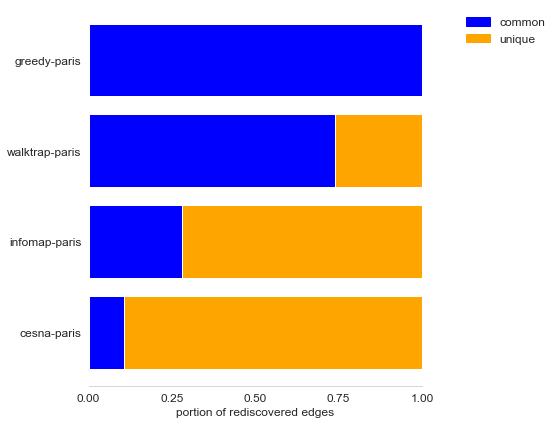

In [26]:
# bar charts of uniqueness

fig, axes = plt.subplots()
fig.set_size_inches(8, 6)
tick_names = []
spaces = '    '

for i,algo in enumerate(algos):
    tick_names.append(algo)
    sub = uniq_rediscovery_df[uniq_rediscovery_df['algo'] == algo]
    common_count = sub[sub['infotype'] == 'common']['count']
    unique_count = sub[sub['infotype'] != 'common']['count']
    common_percent = float(common_count) / (float(common_count) + float(unique_count))
    print(common_percent)
    print(algo, float(common_count) + float(unique_count))
    b1 = axes.barh(-i, common_percent, color="blue")
    b2 = axes.barh(-i, 1 - common_percent, left=common_percent, color="orange")
#     plt.text( common_percent / 2, i, 'common {}%'.format(round(common_percent,2)),fontsize=std_fontsize)
clear_ax(axes,bottom=True)
plt.yticks([-1*x for x in range(4)], tick_names, fontsize=std_fontsize)
plt.xticks([0.00,.25,.5,.75,1.00], fontsize=std_fontsize)
plt.xlabel('portion of rediscovered edges', fontsize=std_fontsize)
common_patch = mpatches.Patch(color='blue', label='common')
unique_patch = mpatches.Patch(color='orange', label='unique')
plt.legend(handles=[common_patch, unique_patch], bbox_to_anchor=(1.1, 1), frameon=False, fontsize=std_fontsize)
plt.tight_layout()
plt.savefig('../PublicationFigures/rediscovery_comon_uniq_bars.png',dpi=300)
plt.show() 

In [27]:
# print(len(global_all_rediscoveries))
# print(len(global_all_rediscoveries_set))
print(uniq_rediscovery_df)
print('common', uniq_rediscovery_df[uniq_rediscovery_df['infotype'] == 'common']['count'].sum())
print('unique', uniq_rediscovery_df[uniq_rediscovery_df['infotype'] == 'unique']['count'].sum())
print('total',uniq_rediscovery_df['count'].sum())

             algo infotype  count
0  walktrap-paris   common    257
1  walktrap-paris   unique     90
2   infomap-paris   common     62
3   infomap-paris   unique    160
4    greedy-paris   common    226
5    greedy-paris   unique      0
6     cesna-paris   common     54
7     cesna-paris   unique    450
common 599
unique 700
total 1299


## Up Set Plots
https://upsetplot.readthedocs.io/en/stable/

cesna-paris,greedy-paris,infomap-paris,walktrap-paris 3
,greedy-paris,infomap-paris,walktrap-paris 33
,cesna-paris,infomap-paris,walktrap-paris 5
,,infomap-paris,walktrap-paris 49
,cesna-paris,greedy-paris,walktrap-paris 24
,,greedy-paris,walktrap-paris 226
,,cesna-paris,walktrap-paris 41
,,,walktrap-paris 347
,cesna-paris,greedy-paris,infomap-paris 3
,,greedy-paris,infomap-paris 33
,,cesna-paris,infomap-paris 18
,,,infomap-paris 222
,,cesna-paris,greedy-paris 24
,,,greedy-paris 226
,,,cesna-paris 504
[['cesna-paris', 'greedy-paris', 'infomap-paris', 'walktrap-paris'], ['walktrap-paris', 'infomap-paris', 'greedy-paris'], ['walktrap-paris', 'infomap-paris', 'cesna-paris'], ['walktrap-paris', 'infomap-paris'], ['walktrap-paris', 'greedy-paris', 'cesna-paris'], ['walktrap-paris', 'greedy-paris'], ['walktrap-paris', 'cesna-paris'], ['walktrap-paris'], ['infomap-paris', 'greedy-paris', 'cesna-paris'], ['infomap-paris', 'greedy-paris'], ['infomap-paris', 'cesna-paris'], ['infomap-paris'], ['

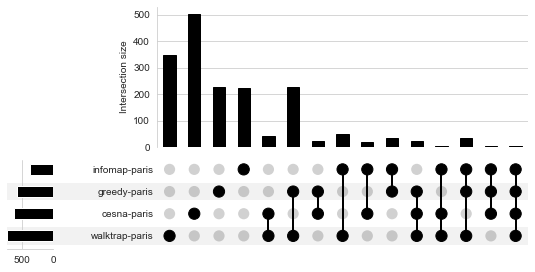

In [25]:
# print(clusters_dict_2021.keys())
# print(clusters_dict_2021[tmp_name])

def remove_items(test_list, item):
 
    # using list comprehension to perform the task
    res = [i for i in test_list if i != item]
 
    return res

plt_categories = []
plt_counts = []
upset_plot_results = {}
keys = list(clusters_dict_2021.keys()) + ['']
for key1 in list(clusters_dict_2021.keys()):
    set1 = set(clusters_dict_2021[key1])
    for key2 in keys:
        if key2 != '':
            set2 = set(clusters_dict_2021[key2])
            s12 = set2.intersection(set1)
        else:
            s12 = set1
        for key3 in keys:
            if key3 != '':
                set3 = set(clusters_dict_2021[key3])
                s123 = s12.intersection(set3)
            else:
                s123 = s12
            for key4 in keys:
                if key4 != '':
                    set4 = set(clusters_dict_2021[key4])
                    s1234 = s123.intersection(set4)
                else:
                    s1234 = s123
                these_keys = [key1,key2,key3,key4]
                these_keys2 = these_keys
                if '' in these_keys2:
                    these_keys2 = remove_items(these_keys2, '')
                if len(these_keys2) != len(set(these_keys2)):
                    continue
                these_keys.sort()
                if ','.join(these_keys) in upset_plot_results:
                    continue
                upset_plot_results[','.join(these_keys)] = len(s1234)
                plt_categories.append(these_keys2)
                plt_counts.append(len(s1234))
                    
for k in upset_plot_results.keys():
    print(k, upset_plot_results[k])

print(plt_categories)
print(plt_counts)
example = from_memberships(plt_categories,data=plt_counts)
plot(example)
plt.savefig('../PublicationFigures/upsetplot.png',dpi=300)

## Rediscoveries year after year

In [30]:
# load 2019 coms
g_subcoms_19 = load_clusters('../SubComs/2019/paris.greedy.2019.coms.txt')
w_subcoms_19 = load_clusters('../SubComs/2019/paris.walktrap.2019.coms.txt')
i_subcoms_19 = load_clusters('../SubComs/2019/paris.infomap.2019.coms.txt')
c_subcoms_19 = load_clusters('../SubComs/2019/paris.cesna.2019.coms.txt')

# print total numbe of coms
print('total number of coms')
print(len(g_subcoms_19) + len(w_subcoms_19) + len(i_subcoms_19) + len(c_subcoms_19))

# remove trivial coms
g_subcoms_19 = remove_trivial_coms(g_subcoms_19)
w_subcoms_19 = remove_trivial_coms(w_subcoms_19)
i_subcoms_19 = remove_trivial_coms(i_subcoms_19)
c_subcoms_19 = remove_trivial_coms(c_subcoms_19)

print('total number of non-trivial coms')
print(len(g_subcoms_19) + len(w_subcoms_19) + len(i_subcoms_19) + len(c_subcoms_19))



total number of coms
41968
total number of non-trivial coms
1323


In [31]:
def get_possible_pairs_from_com(coms,_G):
    # this function returns a list of all possible pairings of genes and phenotypes in all clusters - regardless of if they exist or not
    pairs = set()
    for com in coms:
        genes = [x for x in com.members if 'HP:' not in x]
        hpos = [x for x in com.members if 'HP:' in x]
#         print('HPOs',len(hpos))
#         print('Genes',len(genes))
        if len(genes) == 0 or len(hpos) == 0:
            continue
        if len(genes) == 1 and len(hpos) == 1:
            continue
        for g in genes:
            for h in hpos:
                if _G.has_edge(g,h):
                    continue
                p=[g,h]
                p.sort()
                pairs.add(str(p))
    return pairs

def get_possible_pairs_for_each_com(coms,_G):
    # return a list with an index for each com, each index has a set of unique pairs for that corresponding cluster
    # this function returns a list of all possible pairings of genes and phenotypes in all clusters - regardless of if they exist or not
    pairs = []
    for com in coms:
        genes = [x for x in com.members if 'HP:' not in x]
        hpos = [x for x in com.members if 'HP:' in x]
        # remove trivial coms
        if len(genes) == 0 or len(hpos) == 0:
            continue
        if len(genes) == 1 and len(hpos) == 1:
            continue
        pairs.append(set())
        for g in genes:
            for h in hpos:
                if _G.has_edge(g,h):
                    continue
                p=[g,h]
                p.sort()
                pairs[-1].add(str(p))
    return pairs

g_subcoms_19_pairs = get_possible_pairs_from_com(g_subcoms_19,G19)
w_subcoms_19_pairs = get_possible_pairs_from_com(w_subcoms_19,G19)
i_subcoms_19_pairs = get_possible_pairs_from_com(i_subcoms_19,G19)
c_subcoms_19_pairs = get_possible_pairs_from_com(c_subcoms_19,G19)
print(len(g_subcoms_19))
print(len(g_subcoms_19_pairs))
print(len(w_subcoms_19_pairs))
print(len(i_subcoms_19_pairs))
print(len(c_subcoms_19_pairs))

g_19_com_specific_pairs = get_possible_pairs_for_each_com(g_subcoms_19,G19)
w_19_com_specific_pairs = get_possible_pairs_for_each_com(w_subcoms_19,G19)
i_19_com_specific_pairs = get_possible_pairs_for_each_com(i_subcoms_19,G19)
c_19_com_specific_pairs = get_possible_pairs_for_each_com(c_subcoms_19,G19)

171
47812
43030
37899
15093


In [32]:
def load_new_edges(el):
    pairs = set()
    for line in open(el,'r'):
        row = line.strip().split('\t')
        row.sort()
        pairs.add(str(row))
    return pairs

new_19_pairs = load_new_edges('../g2p_Edgelists/String_HPO_2019.phenotypic_branch.g2p_edgelist.txt')
new_20_pairs = load_new_edges('../g2p_Edgelists/String_HPO_2020.phenotypic_branch.g2p_edgelist.txt')
new_21_pairs = load_new_edges('../g2p_Edgelists/String_HPO_2021.phenotypic_branch.g2p_edgelist.txt')
new_22_pairs = load_new_edges('../g2p_Edgelists/String_HPO_2022.phenotypic_branch.g2p_edgelist.txt')
print(len(new_20_pairs))
print(len(new_21_pairs))
print(len(new_22_pairs))

# remove edges that are in 19 already
new_20_pairs = set([x for x in new_20_pairs if x not in new_19_pairs])
new_21_pairs = set([x for x in new_21_pairs if x not in new_19_pairs])
new_22_pairs = set([x for x in new_22_pairs if x not in new_19_pairs])

print(len(new_20_pairs))
print(len(new_21_pairs))
print(len(new_22_pairs))

new_21_vs_20_pairs = [x for x in new_21_pairs if x not in new_20_pairs]
print('Number of possible new edges 2021 v 2022', len(new_21_vs_20_pairs))


170892
197926
210413
130314
158358
171489
Number of possible new edges 2021 v 2022 31838


In [33]:
print(list(new_20_pairs)[1])
print(type(list(new_20_pairs)[1]))
print(list(g_subcoms_19_pairs)[0:5])

['HP:0000992', 'PWAR1']
<class 'str'>
["['FAM21C', 'HP:0100774']", "['HP:0002960', 'KLRC4']", "['HP:0000286', 'NMNAT1']", "['CCND2', 'HP:0008250']", "['HP:0004099', 'RHOG']"]


Number of unique pairs found in year 2020 696
Number of unique pairs found in year 2021 1011
Number of unique pairs found in year 2022 1107


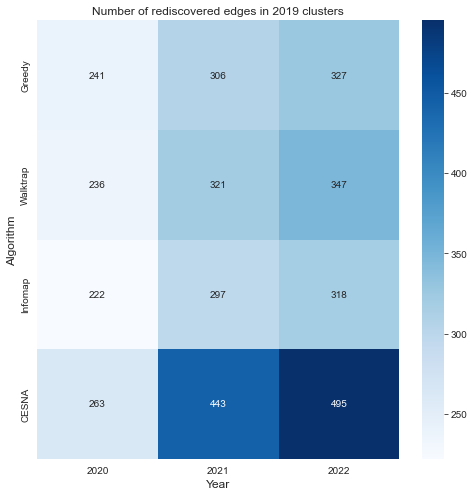

In [34]:
def rediscover(pairs, el_pairs):
    # find the intersection
    return pairs.intersection(el_pairs)

# year: set of pairs
all_pairs = {}
look_forward_res = np.zeros((4,3))
for a, algo, i in zip([g_subcoms_19_pairs,w_subcoms_19_pairs,i_subcoms_19_pairs,c_subcoms_19_pairs],['greedy','waltrap','infomap','cesna'],range(4)):
    for e, y, j in zip([new_20_pairs,new_21_pairs,new_22_pairs], ['2020','2021','2022'], range(3)):
        if y not in all_pairs:
            all_pairs[y] = set()
        num_r = rediscover(a,e)
        all_pairs[y] = all_pairs[y].union(num_r)
        
        look_forward_res[i,j] = len(num_r)
for y in all_pairs.keys():
    print('Number of unique pairs found in year {}'.format(y), len(all_pairs[y]))

# heatmap with  labels and annotations of look_forward_res uisng seaborn
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(look_forward_res, annot=True, fmt='g', ax=ax, cmap='Blues', xticklabels=['2020','2021','2022'], yticklabels=['Greedy','Walktrap','Infomap','CESNA'])
ax.set_xlabel('Year', fontsize=std_fontsize)
ax.set_ylabel('Algorithm', fontsize=std_fontsize)
ax.set_title('Number of rediscovered edges in 2019 clusters', fontsize=std_fontsize)
plt.tight_layout()
plt.savefig('../PublicationFigures/look_forward_rediscovery.png',dpi=300)
plt.show()


[[ 52.  59.  64.]
 [ 43.  46.  54.]
 [ 33.  35.  42.]
 [127. 177. 194.]]
Number of 2019 clusters with at least 1 rediscovery in 2020 255.0


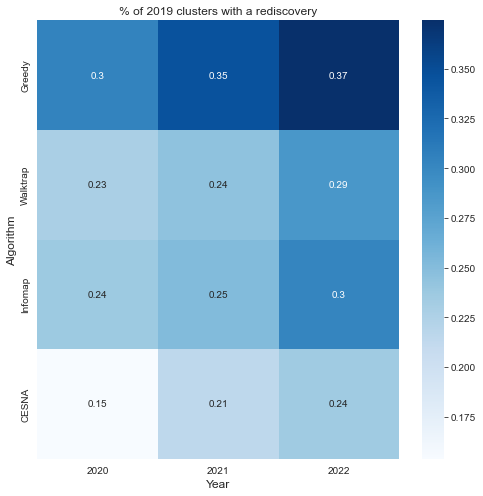

In [35]:
# how many clusters have a rediscovered edge in each year?

look_forward_res_com_counts = np.zeros((4,3))
for a, algo, i in zip([g_19_com_specific_pairs,w_19_com_specific_pairs,i_19_com_specific_pairs,c_19_com_specific_pairs],['greedy','waltrap','infomap','cesna'],range(4)):
    for e, y, j in zip([new_20_pairs,new_21_pairs,new_22_pairs], ['2020','2021','2022'], range(3)):
        # count the number of coms in a that have atleast 1 rediscovery
        # for each com, find the rediscoveries
        has_r_count = 0
        for c in a:
            num_r = rediscover(c,e)
            if len(num_r) > 0:
                look_forward_res_com_counts[i,j] += 1

print(look_forward_res_com_counts)
# how many of the 2019 clusters at least 1 rediscovery in 2020?
print('Number of 2019 clusters with at least 1 rediscovery in 2020', np.sum(look_forward_res_com_counts[:,0]))

# normalize look_forward_res_com_counts by the number of coms in each algo
for a, algo, i in zip([g_19_com_specific_pairs,w_19_com_specific_pairs,i_19_com_specific_pairs,c_19_com_specific_pairs],['greedy','waltrap','infomap','cesna'],range(4)):
    for j in range(3):
        look_forward_res_com_counts[i,j] = look_forward_res_com_counts[i,j] / len(a)
    

# heatmap with  labels and annotations of look_forward_res_com_counts uisng seaborn, found values to 2 decimal places
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(look_forward_res_com_counts, annot=True, fmt='.2g', ax=ax, cmap='Blues', xticklabels=['2020','2021','2022'], yticklabels=['Greedy','Walktrap','Infomap','CESNA'])
ax.set_xlabel('Year', fontsize=std_fontsize)
ax.set_ylabel('Algorithm', fontsize=std_fontsize)
ax.set_title('% of 2019 clusters with a rediscovery', fontsize=std_fontsize)
plt.tight_layout()
plt.savefig('../PublicationFigures/look_forward_rediscovery_com_percents.png',dpi=300)
plt.show()


## Classification Genetic Algorithm

     gen  nevals   fitness  fitness_std  fitness_max  fitness_min  threshold
0      0      40  0.682871     0.010436     0.705818     0.657151        0.1
1      1      80  0.691455     0.006419     0.703433     0.673943        0.1
2      2      80  0.696046     0.005429     0.706182     0.683347        0.1
3      3      80  0.699514     0.003787     0.706182     0.686324        0.1
4      4      80  0.702846     0.003627     0.716224     0.694578        0.1
..   ...     ...       ...          ...          ...          ...        ...
399   96      80  0.759211     0.004588     0.760654     0.739375        1.0
400   97      80  0.760176     0.002101     0.760654     0.749855        1.0
401   98      80  0.760355     0.001867     0.760654     0.748697        1.0
402   99      80  0.759630     0.003181     0.760654     0.746354        1.0
403  100      80  0.759419     0.003949     0.760654     0.742184        1.0

[404 rows x 7 columns]


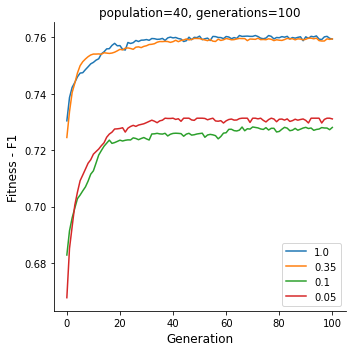

In [5]:
# just_regression_genetic_algo.tsv
gaoregress = pd.read_csv('../train_19_20_genetic_algo_outputs.txt', sep='\t',comment='#')
print(gaoregress)

fig, ax = plt.subplots(figsize=(5,5))

for t in [1.00,0.35,0.10,0.05]:
    sub = gaoregress[gaoregress['threshold'] == t]
    plt.plot(sub['gen'], sub['fitness'], label=t)
plt.xlabel('Generation', fontsize=std_fontsize)
plt.ylabel('Fitness - F1', fontsize=std_fontsize)
plt.title('population=40, generations=100', fontsize=std_fontsize)
# remove top and right spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('../PublicationFigures/train_19_20_genetic_algo_outputs.png',dpi=300)
plt.show()

## CHCO Patients